In [134]:
!pip install kneed

In [135]:
import warnings
import numpy as np 
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from kneed import KneeLocator
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn import preprocessing, decomposition
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline 

%matplotlib inline
np.random.seed(1)
warnings.filterwarnings('ignore')

In [136]:
df_train = pd.read_csv(r"C:\Users\Lenovo\Downloads\Train (1).csv")
df_test = pd.read_csv(r"C:\Users\Lenovo\Downloads\Test (1).csv")


In [137]:
print("Training data shape is: ",df_train.shape)
print("\nTesting data shape is: ",df_test.shape)

Training data shape is:  (8068, 11)

Testing data shape is:  (2627, 10)


In [138]:
df_train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [139]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


# As you can see most of the data types are object so we need to convert them into numerical variables

In [140]:
df_train.describe()

,ID,Age,Work_Experience,Family_Size
count,8068.000000,8068.000000,7239.000000,7733.000000
mean,463479.214551,43.466906,2.641663,2.850123
std,2595.381232,16.711696,3.406763,1.531413
min,458982.000000,18.000000,0.000000,1.000000
25%,461240.750000,30.000000,0.000000,2.000000
50%,463472.500000,40.000000,1.000000,3.000000
75%,465744.250000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


In [141]:
#Check if we have duplicate applicants
duplicates=df_train[df_train.duplicated(subset = df_train.columns.drop("Segmentation"))]
duplicates

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation


In [142]:
#Check for null values in the data
df_train.isnull().any()

ID                 False
Gender             False
Ever_Married        True
Age                False
Graduated           True
Profession          True
Work_Experience     True
Spending_Score     False
Family_Size         True
Var_1               True
Segmentation       False
dtype: bool

In [143]:
train_without_nan = len(df_train.drop(columns ="Segmentation").dropna())
test_without_nan = len(df_test.dropna())
print(f"\nPercentage of applicants who have at least one null feature - TRAIN - {(1-train_without_nan/len(df_train))*100}")
print(f"Percentage of applicants who have at least one null feature - TEST -  {(1-test_without_nan/len(df_test))*100}\n")


Percentage of applicants who have at least one null feature - TRAIN - 17.389687654933073
Percentage of applicants who have at least one null feature - TEST -  18.00532927293491



In [144]:
null_df = pd.concat([pd.DataFrame(df_train.isna().sum()),pd.DataFrame(df_test.isna().sum())],axis=1)
null_df.columns = ["Train_Nan","Test_Nan"]
null_df


,Train_Nan,Test_Nan
ID,0,0.0
Gender,0,0.0
Ever_Married,140,50.0
Age,0,0.0
Graduated,78,24.0
Profession,124,38.0
Work_Experience,829,269.0
Spending_Score,0,0.0
Family_Size,335,113.0
Var_1,76,32.0


In [145]:
#As we see null values are 17% of our data so we can't drop them we need to fill.
#But I have to drop applicants who have 3 or more null features because if I fill them they will not be accurate
#Here is the percentage of such applicants

print(f"\nPercentage of applicants who have 3 or more null feature - TRAIN - \
{len(df_train.loc[df_train.isnull().sum(axis=1)>=3])/len(df_train)*100}")

print(f"Percentage of applicants who have 3 or more null feature - TEST  - \
{len(df_test.loc[df_test.isnull().sum(axis=1)>=3])/len(df_test)*100}")


Percentage of applicants who have 3 or more null feature - TRAIN - 0.23549826474962818
Percentage of applicants who have 3 or more null feature - TEST  - 0.22839741149600304


In [146]:
#As we see the number of such applicants is 0.2 percent of our data so we can drop them

In [147]:
print(f"Train data shape before {df_train.shape}")
print(f"Test  data shape before {df_test.shape}")

df_train.drop((df_train.loc[df_train.isnull().sum(axis=1)>=3]).index,axis='index',inplace=True)
df_test.drop((df_test.loc[df_test.isnull().sum(axis=1)>=3]).index,axis='index',inplace=True)

print(f"\nTrain data shape after {df_train.shape}")
print(f"Test  data shape after {df_test.shape}")

Train data shape before (8068, 11)
Test  data shape before (2627, 10)

Train data shape after (8049, 11)
Test  data shape after (2621, 10)


In [148]:
#checking the null values where number of null columns are less than 3

null_df1 = pd.concat([pd.DataFrame(df_train.isna().sum()),pd.DataFrame(df_test.isna().sum())],axis=1)
null_df1.columns = ["Train_Nan","Test_Nan"]
null_df1


,Train_Nan,Test_Nan
ID,0,0.0
Gender,0,0.0
Ever_Married,134,48.0
Age,0,0.0
Graduated,72,23.0
Profession,113,35.0
Work_Experience,813,264.0
Spending_Score,0,0.0
Family_Size,320,109.0
Var_1,72,29.0


In [149]:
train_without_nan = len(df_train.drop(columns ="Segmentation").dropna())
test_without_nan = len(df_test.dropna())
print(f"\nPercentage of applicants who have at least one null feature - TRAIN - {(1-train_without_nan/len(df_train))*100}")
print(f"Percentage of applicants who have at least one null feature - TEST -  {(1-test_without_nan/len(df_test))*100}\n")


Percentage of applicants who have at least one null feature - TRAIN - 17.194682569263264
Percentage of applicants who have at least one null feature - TEST -  17.81762685997711



In [150]:
#checking unique values of profession column and var_1 column
print(df_train.Profession.unique())
print('\n')
print(df_train.Var_1.unique())

['Healthcare' 'Engineer' 'Lawyer' 'Entertainment' 'Artist' 'Executive'
 'Doctor' 'Homemaker' 'Marketing' nan]


['Cat_4' 'Cat_6' 'Cat_7' 'Cat_3' 'Cat_1' 'Cat_2' nan 'Cat_5']


# Data Visualization

In [151]:
#Let's see distribution of categorical features which have 2 or 3 categories

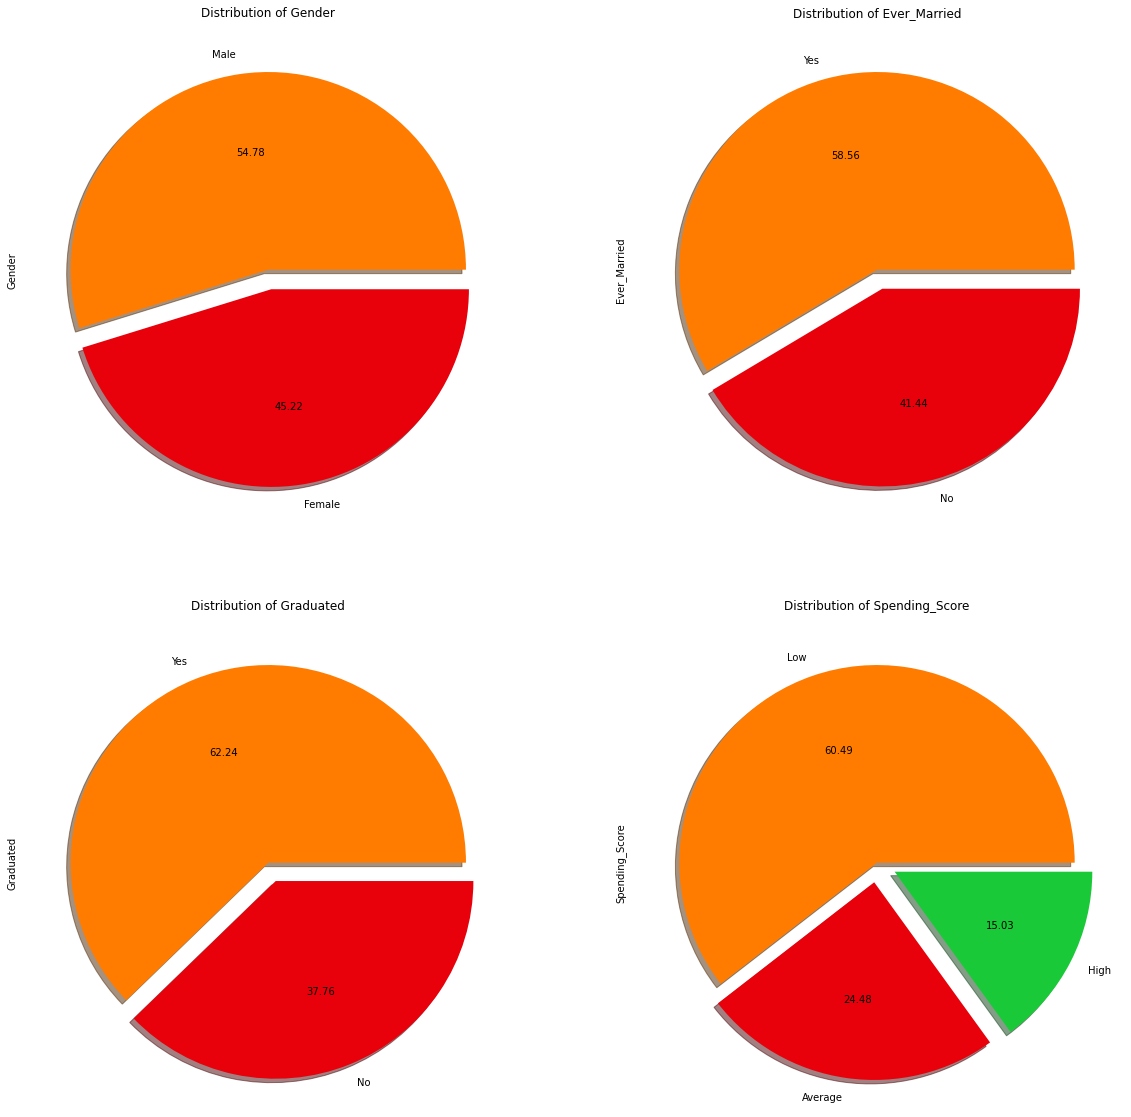

In [152]:
f, ax  = plt.subplots(2,2,figsize = (20,20))
colors=["#FF7C00", "#E8000B","#1AC938"]
df_train['Gender'].value_counts().plot.pie(title='Distribution of Gender',explode=[0,.1],
                                           ax=ax[0][0],autopct="%.2f",shadow = True,colors = colors)

df_train['Ever_Married'].value_counts().plot.pie(title='Distribution of Ever_Married',explode=[0,.1],
                                                 ax=ax[0][1],autopct="%.2f",shadow = True,colors = colors)

df_train['Graduated'].value_counts().plot.pie(title='Distribution of Graduated',explode=[0,.1],
                                              ax=ax[1][0],autopct="%.2f",shadow = True,colors = colors)

df_train['Spending_Score'].value_counts().plot.pie(title='Distribution of Spending_Score',
                                                   ax=ax[1][1],explode=[0,.1,.1],autopct="%.2f",shadow = True,colors=colors)

f.patch.set_facecolor('white')
plt.show()

# most of our customers are men
# married people shop more
# graduates are more likely to shop
# low Spending score 


In [ ]:
#Let's see distribution other categorical features which have a little more categories so I plot them by countplot

<AxesSubplot:xlabel='Var_1', ylabel='count'>

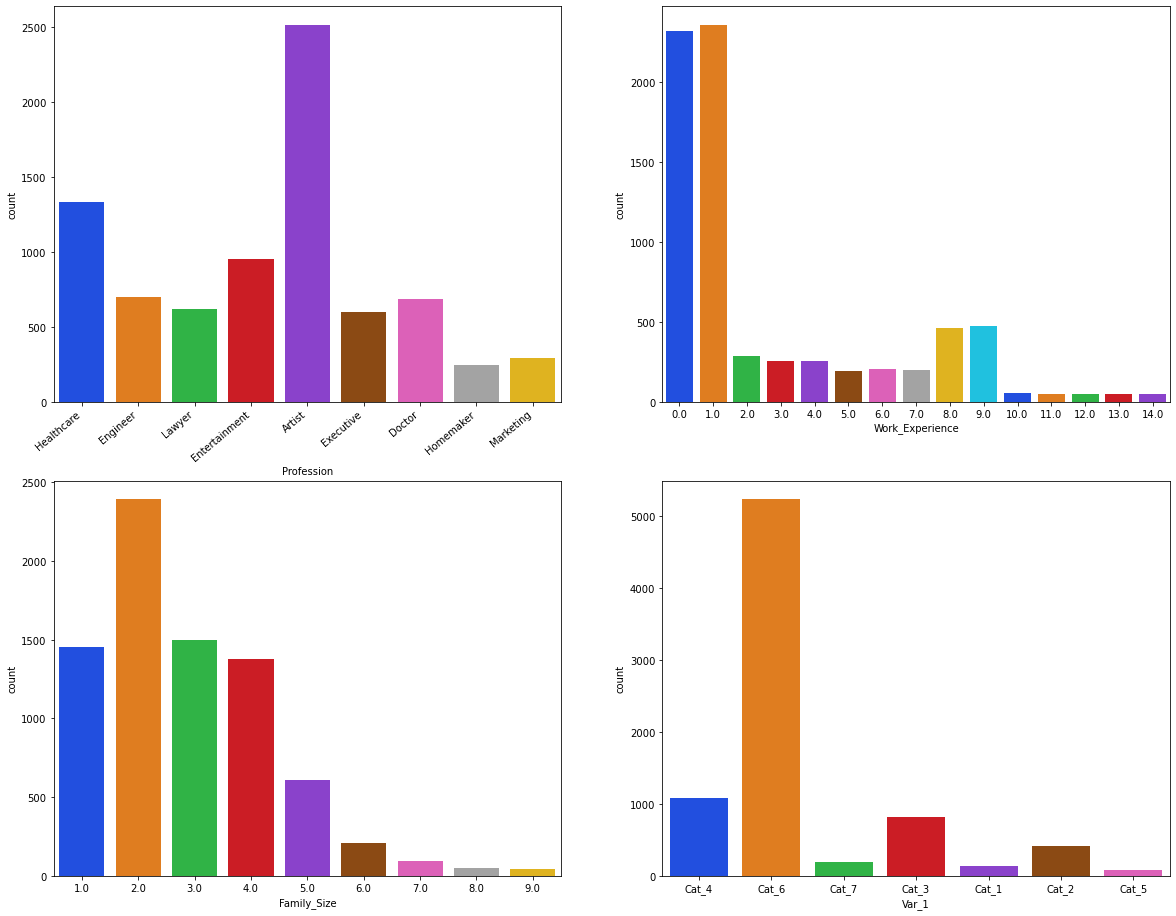

In [153]:
f, ax  = plt.subplots(2,2,figsize = (20,16))
colors=["#023EFF","#FF7C00", "#E8000B","#1AC938"]
labels = ["D","C","A","B"]

ax1 = sns.countplot(df_train['Profession'],ax=ax[0][0],palette = "bright")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right")

sns.countplot(df_train['Work_Experience'],ax=ax[0][1],palette = "bright")
sns.countplot(df_train['Family_Size'],ax=ax[1][0],palette = "bright")
sns.countplot(df_train['Var_1'],ax=ax[1][1],palette = "bright")

### from these plots we can determine that:
###  most of our customers are Artist
### people who have a little work experience
### who have 2 family members
###  most of them are from 6 category

In [155]:
#let us now plot our most varying numerical data 
def createPlot(data, col:str, ttext:str, xtext:str, ytext:str) ->None:
    """
    this function creates histogram and boxplot by pyplot library and also count skewness
    
    Arguments:
    data -- pandas dataframe
    col -- column name which we want to plot
    ttext -- string which we want to write on top of the graph
    xtext -- string which we want to write on x axis
    ytext -- string which we want to write on y axis
    
    Returns:
    None
    """
    plotly.offline.init_notebook_mode(connected=True)
    fig = make_subplots(rows=1, cols=2)
    fig.add_trace(go.Histogram(x=data[col],marker_color='#6a6fff'),row=1,col=1)
    fig.add_trace(go.Box(x=data[col]),row=1,col=2)
    
    fig.update_layout(
        title_text=ttext,
        xaxis_title_text=xtext,
        yaxis_title_text=ytext, 
        bargap=0.05, 
        template = 'plotly_dark',
        width=900, height=600
    )
    
    fig.show()

In [156]:
createPlot(df_train,"Age","Age distribution","Age","count")

# We can see that most of our applicants are in middle age median is 41
# also we don'have applicats in this age 24 34 44 54 64 it's a little surprising 
# why minimum age is 18 and maximum 89


# Class Distribution

<AxesSubplot:xlabel='Segmentation', ylabel='count'>

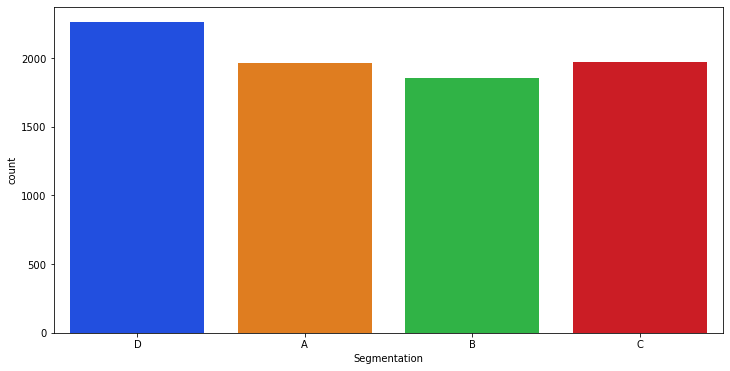

In [157]:
#Also see if the distribution of classes has imbalance


f, ax = plt.subplots(figsize=(12, 6))

sns.countplot(df_train['Segmentation'],palette = "bright")

In [ ]:
# our data is not balanced

# Data Preparation

In [158]:
df_train.head(4)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B


In [159]:
df_train.shape

(8049, 11)

In [130]:
df_test.shape

(2621, 10)

# Label Encoding

In [174]:
def get_encoded_dict(df,lst):
    """
    this function creates dictionary for encoding. Its find unique labels for each column and enumerate them
    
    Arguments:
    df -- pandas dataframe
    lst -- list of columns which we want to encode 
    
    Returns:
    dictionary where key is column name and value is dictionary of unique labels and encoding value
    """
    encoded_dict = {}
    for col in lst:
        each_dict = {}
        sorted_unique_names = df[col].dropna().unique()
        sorted_unique_names.sort()
        for i,val in enumerate(sorted_unique_names):
            each_dict[val] = i
        encoded_dict[col] = each_dict
    return encoded_dict

In [176]:
encoded_dict = get_encoded_dict(df_train,["Gender","Ever_Married","Graduated","Profession","Spending_Score","Var_1","Segmentation"])

duplicates = duplicates.replace(encoded_dict)

df_train = df_train.replace(encoded_dict)
df_test = df_test.replace(encoded_dict)

In [177]:
df_train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,1,0.0,22,0.0,5.0,1.0,2,4.0,3.0,3
1,462643,0,1.0,38,1.0,2.0,NaN,0,3.0,3.0,0
2,466315,0,1.0,67,1.0,2.0,1.0,2,1.0,5.0,1
3,461735,1,1.0,67,1.0,7.0,0.0,1,2.0,5.0,1
4,462669,0,1.0,40,1.0,3.0,NaN,1,6.0,5.0,0


In [ ]:
# FILING NULL VALUES
#We have several methods for this:
# Using (Mean/Median) Values
# Using (Most Frequent) or (Zero/Constant) Values
# Using k-NN
#In this case I will use k-NN method because we don't have big data
#so it will work fast and it consider that we may have similar data

In [178]:
# LET US AGAIN SEE HOW MANY NULL VALUES DO WE HAVE
null_df = pd.concat([pd.DataFrame(df_train.isna().sum()),pd.DataFrame(df_test.isna().sum())],axis=1)
null_df.columns = ["Train_Nan","Test_Nan"]
null_df

,Train_Nan,Test_Nan
ID,0,0.0
Gender,0,0.0
Ever_Married,134,48.0
Age,0,0.0
Graduated,72,23.0
Profession,113,35.0
Work_Experience,813,264.0
Spending_Score,0,0.0
Family_Size,320,109.0
Var_1,72,29.0


# using knn imputer to fill null values

In [179]:
imputer = KNNImputer()

df_train[df_train.columns.drop(["ID","Segmentation"])] = np.round(imputer.fit_transform(df_train.drop(columns = ["ID","Segmentation"])))
df_test[df_test.columns.drop(["ID"])] = np.round(imputer.fit_transform(df_test.drop(columns = ["ID"])))

In [180]:
null_df = pd.concat([pd.DataFrame(df_train.isna().sum()),pd.DataFrame(df_test.isna().sum())],axis=1)
null_df.columns = ["Train_Nan","Test_Nan"]
null_df

,Train_Nan,Test_Nan
ID,0,0.0
Gender,0,0.0
Ever_Married,0,0.0
Age,0,0.0
Graduated,0,0.0
Profession,0,0.0
Work_Experience,0,0.0
Spending_Score,0,0.0
Family_Size,0,0.0
Var_1,0,0.0


In [ ]:
#NOW WE DONT HAVE ANY NAN VALUES

# min max normalization

In [181]:
df_train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,1.0,0.0,22.0,0.0,5.0,1.0,2.0,4.0,3.0,3
1,462643,0.0,1.0,38.0,1.0,2.0,5.0,0.0,3.0,3.0,0
2,466315,0.0,1.0,67.0,1.0,2.0,1.0,2.0,1.0,5.0,1
3,461735,1.0,1.0,67.0,1.0,7.0,0.0,1.0,2.0,5.0,1
4,462669,0.0,1.0,40.0,1.0,3.0,5.0,1.0,6.0,5.0,0


In [182]:
scaler = MinMaxScaler()

columns_to_normalize = ['Age','Profession','Work_Experience','Spending_Score','Family_Size','Var_1']

df_train[columns_to_normalize] = scaler.fit_transform(df_train[columns_to_normalize])
df_test[columns_to_normalize] = scaler.fit_transform(df_test[columns_to_normalize])

df_train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,1.0,0.0,0.056338,0.0,0.625,0.071429,1.0,0.375,0.500000,3
1,462643,0.0,1.0,0.281690,1.0,0.250,0.357143,0.0,0.250,0.500000,0
2,466315,0.0,1.0,0.690141,1.0,0.250,0.071429,1.0,0.000,0.833333,1
3,461735,1.0,1.0,0.690141,1.0,0.875,0.000000,0.5,0.125,0.833333,1
4,462669,0.0,1.0,0.309859,1.0,0.375,0.357143,0.5,0.625,0.833333,0


In [ ]:
#clearly all my values are now in the range of 0 and 1

# let's look at correlation matrix

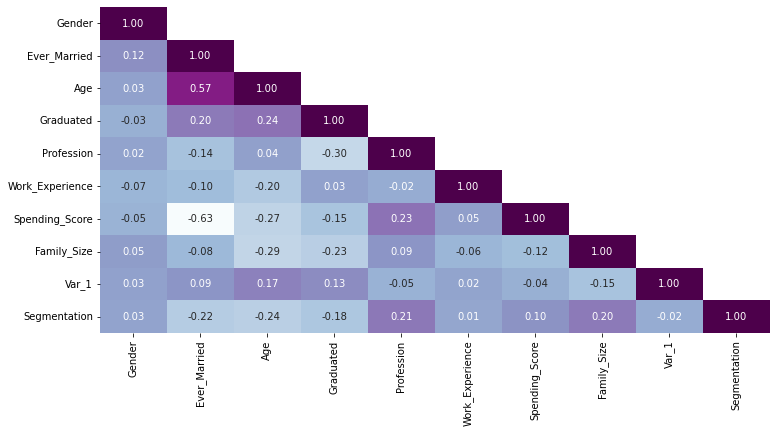

In [189]:
matrix = df_train.drop(columns=["ID"]).corr()
f, ax = plt.subplots(figsize=(12, 6))
with sns.axes_style("dark"):
    sns.heatmap(matrix,mask=np.triu(matrix,1),annot=True,fmt=".2f", vmax=.8,cbar=False,cmap="BuPu");

### we can see that age and ever_married are positively highly correlated
###  Also,spending score and ever_married are negatively highly correlated  

#  check feature importance 

In [ ]:
#Plot bar charts which will show feature importances.
#For this plot I will use Decision Trees which is one of the most appropriate method for this kind of finding

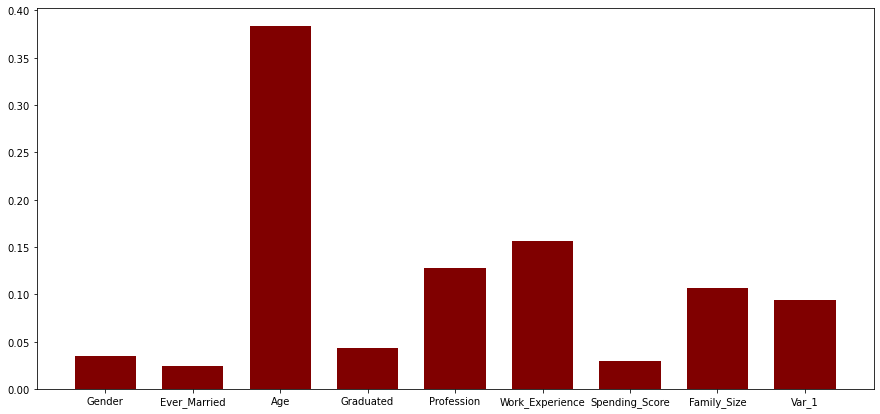

In [206]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(columns=["ID","Segmentation"]), 
                                                    df_train["Segmentation"], test_size=0.3, random_state=42)

model = DecisionTreeRegressor()
model.fit(X_train, y_train)
importance = model.feature_importances_

# plot feature importance
fig = pyplot.figure(figsize =(15, 7))
pyplot.bar([x for x in df_train.drop(columns=["ID","Segmentation"]).columns], importance,width =0.7,color= 'maroon')
pyplot.show()

#### From this plot we can find the least important variable which is "Ever_Married"
#### But  we can't drop it because as we saw in correlation matrix "Ever_Married" and "Spending_Score" are high correlated(negatively)

In [ ]:
# Now we can create a model
#let's create K-means model with different clusters and see Elbow plot

In [ ]:
#I will use "Gender" and "Spending_Score" in reporting variables

In [223]:
wcss=[]       #dictionary
for i in range(1,10):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
    kmeans.fit(df_train.drop(columns=["ID","Segmentation","Gender","Spending_Score"]))
    wcss.append(kmeans.inertia_)

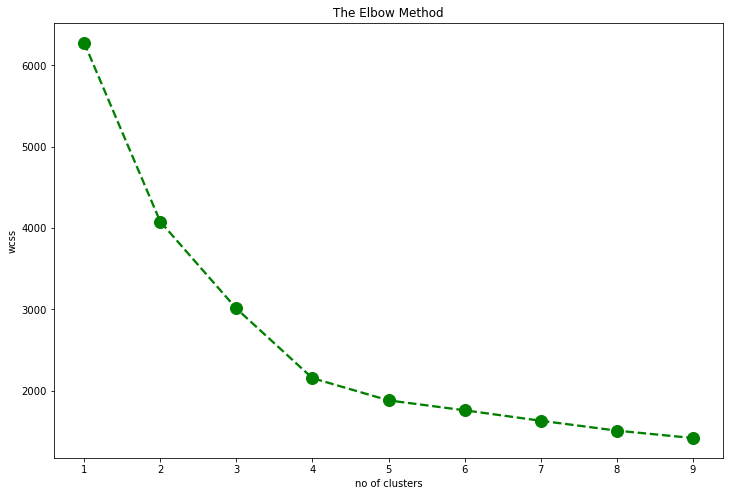

In [234]:
plt.figure(figsize=(12,8))
plt.plot(range(1,10), wcss,'go--',linewidth=2.3,markersize=12)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('wcss')
plt.show()

#### As we see Elbow Method shows that we should get 4 clusters
#### But if we want to make sure try kneelocator

In [235]:
kl = KneeLocator(range(1, 10), wcss, curve="convex", direction="decreasing")
kl.elbow

4

### This also showed that 4 clusters are optimal

### Now we need to plot this data and see how k-means separate them
### so we should use PCA algorithm to reduction dimension and plot

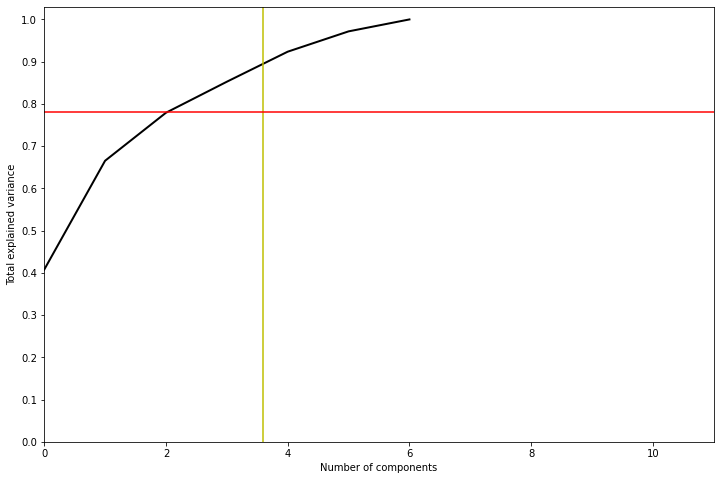

In [249]:
pca = PCA().fit(df_train.drop(columns=["ID","Segmentation","Gender","Spending_Score"]))

plt.figure(figsize=(12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 11)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(3.6, c='y')
plt.axhline(0.78, c='r')
plt.show();

### This plot shows that 2 component is enough to see Data so we will see clear picture

In [237]:
pca = PCA().fit(df_train.drop(columns=["ID","Segmentation","Gender","Spending_Score"]))
data_pca = pca.transform(df_train.drop(columns=["ID","Segmentation","Gender","Spending_Score"]))
data_pca = pd.DataFrame(data_pca)

<AxesSubplot:>

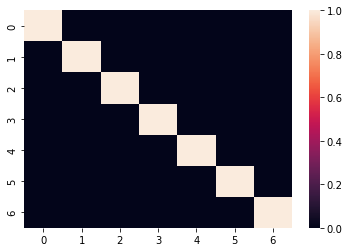

In [238]:
sns.heatmap(data_pca.corr())

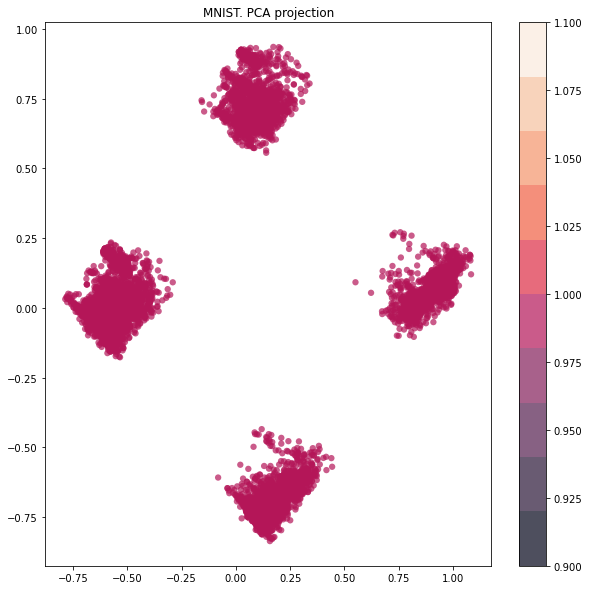

In [260]:
pca = decomposition.PCA(n_components=2)
X_reduced_train = pca.fit_transform(df_train.drop(columns=["ID","Segmentation","Gender","Spending_Score"]))

plt.figure(figsize=(10,10))
plt.scatter(X_reduced_train[:, 0], X_reduced_train[:, 1], c=[1]*df_train.shape[0], 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('rocket', 10))
plt.colorbar()
plt.title('MNIST. PCA projection');

### With this picture we have made sure once again that the number of optimal classes is 4
### It's data distribution and let's see how it would be separated with KMeans

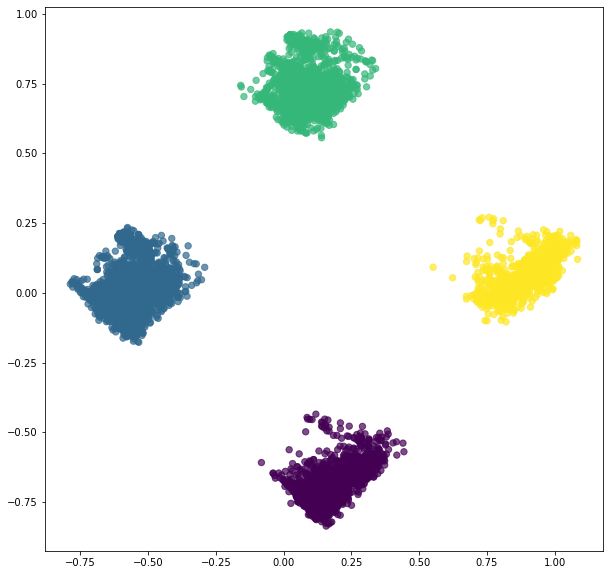

In [253]:
f, ax  = plt.subplots(figsize = (10,10))

kmeansmodel = KMeans(n_clusters= 4, init='k-means++',random_state=0)
y_kmeans_train = kmeansmodel.fit_predict(X_reduced_train)

plt.scatter(X_reduced_train[:,0], X_reduced_train[:,1], c=y_kmeans_train, alpha=0.7, s=40)

#                                             Test Data

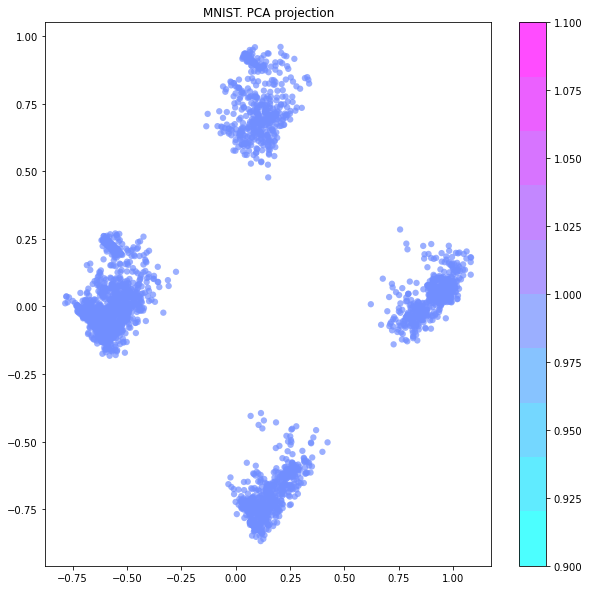

In [262]:
pca = decomposition.PCA(n_components=2)
X_reduced_test = pca.fit_transform(df_test.drop(columns=["ID","Gender","Spending_Score"]))

plt.figure(figsize=(10,10))
plt.scatter(X_reduced_test[:, 0], X_reduced_test[:, 1], c=[1]*df_test.shape[0], 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('cool', 10))
plt.colorbar()
plt.title('MNIST. PCA projection');

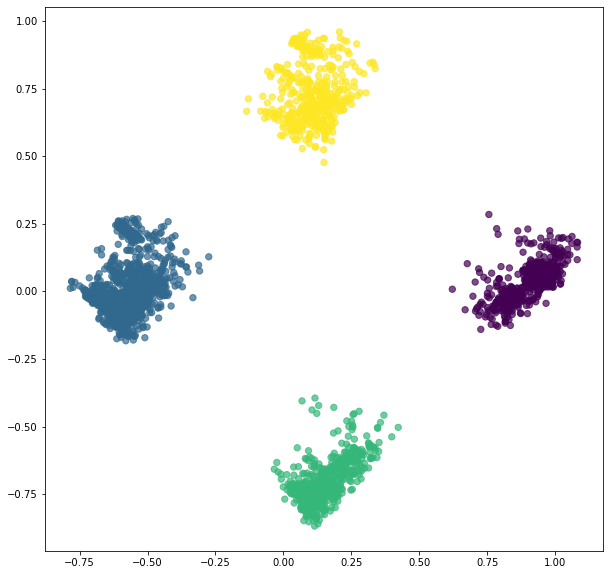

In [263]:
f, ax  = plt.subplots(figsize = (10,10))

kmeansmodel = KMeans(n_clusters= 4, init='k-means++',random_state=0)
y_kmeans_test = kmeansmodel.fit_predict(X_reduced_test)
    
plt.scatter(X_reduced_test[:,0], X_reduced_test[:,1], c=y_kmeans_test, alpha=0.7, s=40)

## As we see test classes are grouped about the same as in the training

### Now we can get the same classes from both the test and training datasets
### compare the distribution of the reporting variables to the given class

In [274]:
df_test=df_test.reset_index()
df_kmeans = pd.DataFrame(y_kmeans_test)
df_kmeans.columns = ["k-means_label"]

df_test=pd.concat([df_test,df_kmeans],axis=1)
df_test

,index,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,k-means_label
0,0,458989,0.0,1.0,0.253521,1.0,0.250,0.000000,1.0,0.000,0.833333,1
1,1,458994,1.0,1.0,0.267606,1.0,0.625,0.571429,0.0,0.375,0.833333,1
2,2,458996,0.0,1.0,0.718310,0.0,0.125,0.000000,1.0,0.000,0.833333,3
3,3,459000,1.0,1.0,0.577465,0.0,0.500,0.785714,0.5,0.125,0.833333,3
4,4,459001,0.0,0.0,0.014085,0.0,1.000,0.142857,1.0,0.375,0.833333,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2616,2622,467954,1.0,0.0,0.154930,0.0,0.625,0.642857,1.0,0.375,0.833333,0
2617,2623,467958,0.0,0.0,0.239437,1.0,0.125,0.071429,1.0,0.000,0.833333,2
2618,2624,467960,0.0,0.0,0.492958,1.0,0.375,0.071429,1.0,0.125,0.833333,2
2619,2625,467961,1.0,1.0,0.408451,1.0,0.500,0.071429,0.5,0.500,0.500000,1


In [275]:
df_train=df_train.reset_index()
df_kmeans = pd.DataFrame(y_kmeans_train)
df_kmeans.columns = ["k-means_label"]

df_train=pd.concat([df_train,df_kmeans],axis=1)
df_train

,index,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,k-means_label
0,0,462809,1.0,0.0,0.056338,0.0,0.625,0.071429,1.0,0.375,0.500000,3,3
1,1,462643,0.0,1.0,0.281690,1.0,0.250,0.357143,0.0,0.250,0.500000,0,1
2,2,466315,0.0,1.0,0.690141,1.0,0.250,0.071429,1.0,0.000,0.833333,1,1
3,3,461735,1.0,1.0,0.690141,1.0,0.875,0.000000,0.5,0.125,0.833333,1,1
4,4,462669,0.0,1.0,0.309859,1.0,0.375,0.357143,0.5,0.625,0.833333,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8044,8063,464018,1.0,0.0,0.056338,0.0,0.750,0.000000,1.0,0.750,0.000000,3,3
8045,8064,464685,1.0,0.0,0.239437,0.0,0.500,0.214286,1.0,0.375,0.500000,3,3
8046,8065,465406,0.0,0.0,0.211268,1.0,0.625,0.071429,1.0,0.000,0.833333,3,0
8047,8066,467299,0.0,0.0,0.126761,1.0,0.625,0.071429,1.0,0.375,0.833333,1,0


In [276]:
# This feature gives us classes separately
def get_classes(df,col,rng):
    _classes = []
    
    for i in range(rng):
        _classes.append(df[df[col]==i])
    
    return _classes

In [277]:
test_class_0, test_class_1, test_class_2, test_class_3 = get_classes(df_test,"k-means_label",4)

train_class_0, train_class_1, train_class_2, train_class_3 = get_classes(df_train,"k-means_label",4)

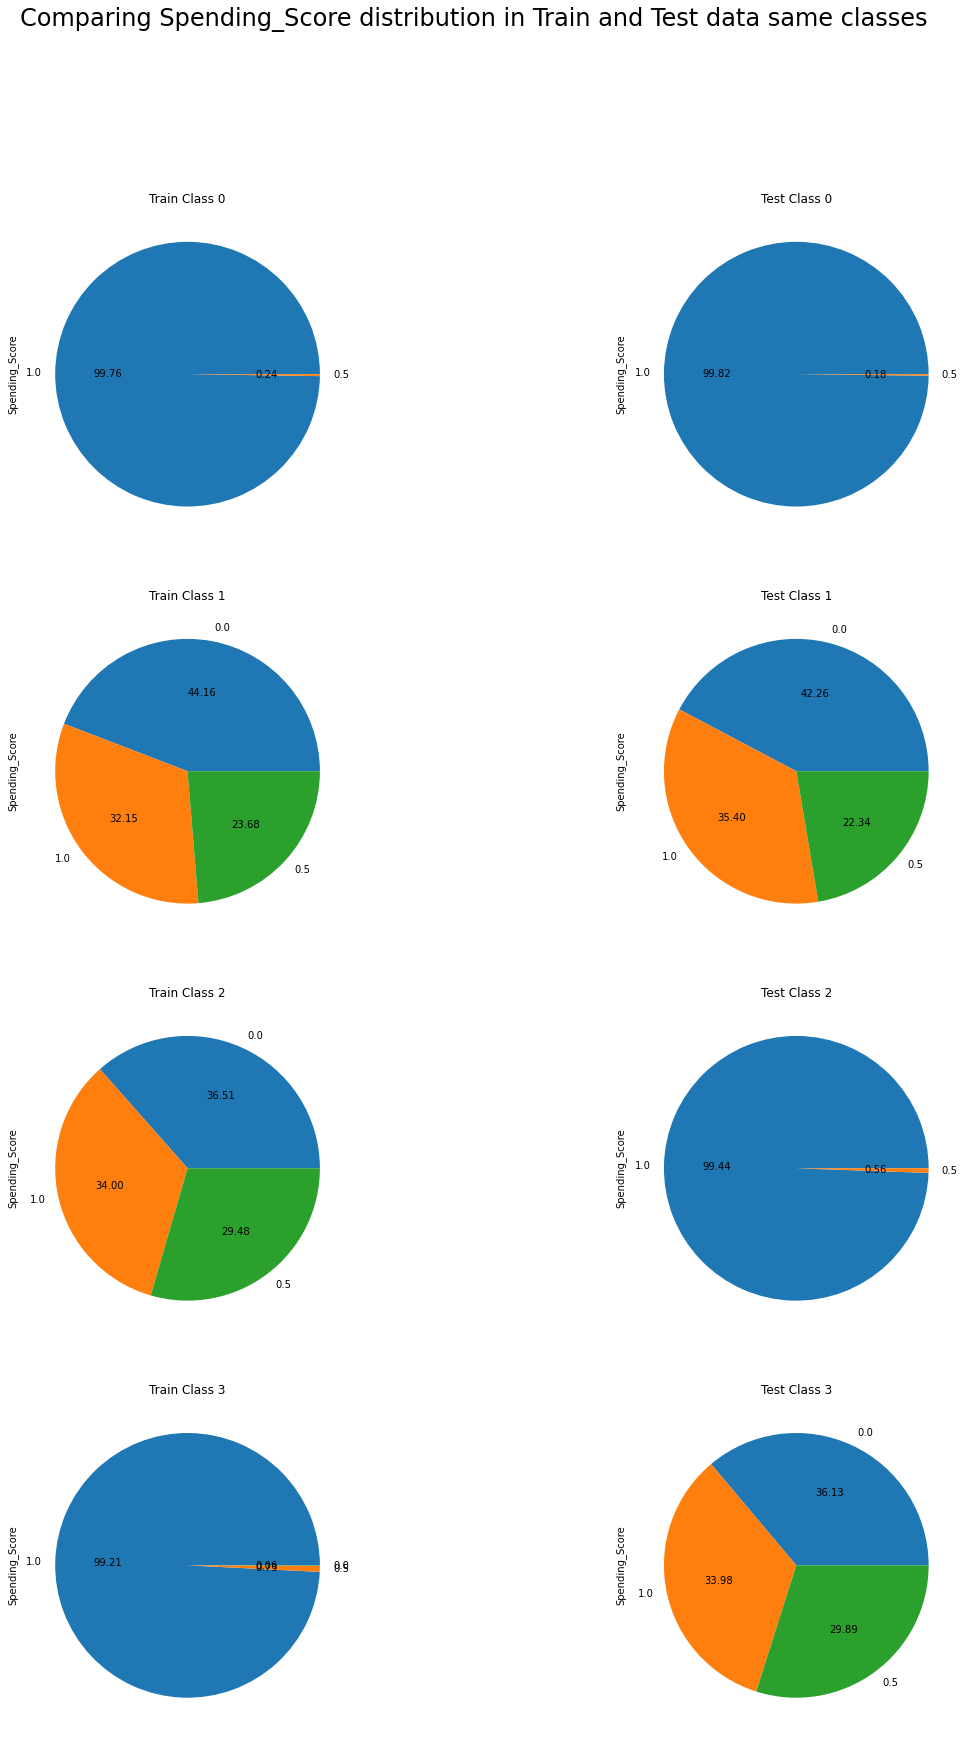

In [285]:
f, ax  = plt.subplots(4,2,figsize = (20,28))
f.suptitle("Comparing Spending_Score distribution in Train and Test data same classes", fontsize=24)

train_class_0['Spending_Score'].value_counts().plot.pie(title='Train Class 0', ax=ax[0][0], autopct="%.2f")
test_class_0['Spending_Score'].value_counts().plot.pie(title='Test Class 0', ax=ax[0][1], autopct="%.2f")

train_class_1['Spending_Score'].value_counts().plot.pie(title='Train Class 1', ax=ax[1][0], autopct="%.2f")
test_class_1['Spending_Score'].value_counts().plot.pie(title='Test Class 1', ax=ax[1][1], autopct="%.2f")

train_class_2['Spending_Score'].value_counts().plot.pie(title='Train Class 2', ax=ax[2][0], autopct="%.2f")
test_class_2['Spending_Score'].value_counts().plot.pie(title='Test Class 2', ax=ax[2][1],autopct="%.2f")

train_class_3['Spending_Score'].value_counts().plot.pie(title='Train Class 3', ax=ax[3][0], autopct="%.2f")
test_class_3['Spending_Score'].value_counts().plot.pie(title='Test Class 3', ax=ax[3][1], autopct="%.2f")

f.patch.set_facecolor('white')
plt.show()


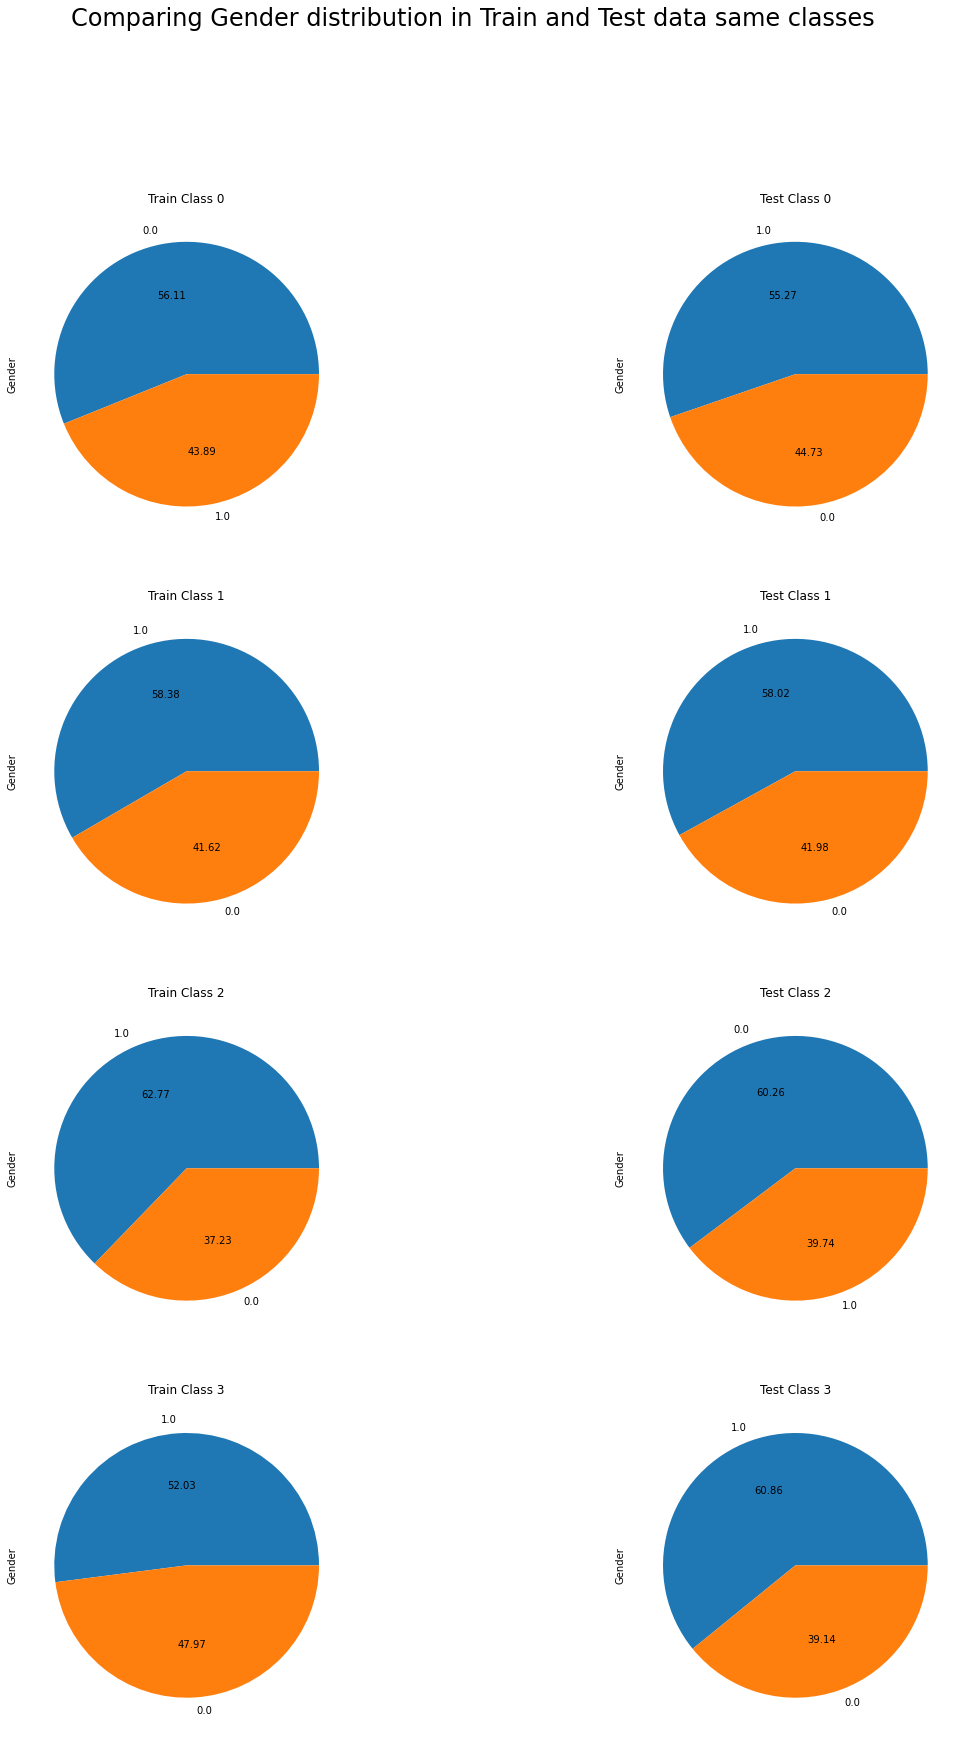

In [283]:
f, ax  = plt.subplots(4,2,figsize = (20,28))
f.suptitle("Comparing Gender distribution in Train and Test data same classes", fontsize=24)

train_class_0['Gender'].value_counts().plot.pie(title='Train Class 0', ax=ax[0][0], autopct="%.2f")
test_class_0['Gender'].value_counts().plot.pie(title='Test Class 0', ax=ax[0][1], autopct="%.2f")

train_class_1['Gender'].value_counts().plot.pie(title='Train Class 1', ax=ax[1][0], autopct="%.2f")
test_class_1['Gender'].value_counts().plot.pie(title='Test Class 1', ax=ax[1][1], autopct="%.2f")

train_class_2['Gender'].value_counts().plot.pie(title='Train Class 2', ax=ax[2][0], autopct="%.2f")
test_class_2['Gender'].value_counts().plot.pie(title='Test Class 2', ax=ax[2][1],autopct="%.2f")

train_class_3['Gender'].value_counts().plot.pie(title='Train Class 3', ax=ax[3][0], autopct="%.2f")
test_class_3['Gender'].value_counts().plot.pie(title='Test Class 3', ax=ax[3][1], autopct="%.2f")

f.patch.set_facecolor('white')
plt.show()

## Hence,it can be clearly seen that the distribution of the Report variables in Test and Train Data are the same